# Tarea 2 Redes Neuronales
* Ignacio Ampuero 201473032-2 (**iampuero**)
* O'bryan Cardenas 201210001-1 (**obryan.cardenas.12**)

> **Nota:** Para facilitar la ejecución del código entrenamos las redes y las guardamos antes de hacer todas las 
> medidas pertinentes que pedían las secciones de la tarea, por ende los codigos de generación de redes no son tan
> precisos y no es recomendable correrlos. Aún así las redes que fueron entrenadas fueron llamadas y probadas para la 
> obtención de valores. El repositorio no posee las redes dado que son aproximadamente sobre 90 y pesan +- 1GB


# 1 Entrenamiento de AE  y RBM en MNIST


In [2]:
#Todos los imports y un par de funciones de la parte 1
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import binomial,standard_normal
from numpy.linalg import norm
import pickle
from keras.datasets import mnist
from keras.layers import Input, Dense
from keras.models import Model,load_model,Sequential
from keras.optimizers import SGD
from keras.utils import np_utils
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.neural_network import BernoulliRBM
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

def clustering_accuracy(pred_labels,y,nclusters=10):
    true_pred = 0.0
    for i in range(0,nclusters):
        mvlabel = np.argmax(np.bincount(y[pred_labels==i]))
        true_pred += sum(y[pred_labels==i] == mvlabel)
    return true_pred/len(y)

#a
def DataLoader():
    nval=1000
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.astype('float32') / 255. #normalización de TrainSet
    x_test = x_test.astype('float32') / 255.  #normalización de TestSet
    x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
    x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
    x_val = x_train[-nval:]
    y_val = y_train[-nval:]
    x_train = x_train[:-nval]
    y_train = y_train[:-nval]
    Y_train = np_utils.to_categorical(y_train, 10)
    Y_val = np_utils.to_categorical(y_val, 10)
    Y_test = np_utils.to_categorical(y_test, 10)
    return (x_train,Y_train),(x_test,Y_test),(x_val,Y_val)

(x_train,Y_train),(x_test,Y_test),(x_val,Y_val) = DataLoader()
print "Datos Cargados e Imports completos"

def ReconError(Original,Predicted): #Reconstruction error -> Average distance original-predicted
    return np.mean([norm(Original[n]-Predicted[n]) for n in range(len(Original))])
        

Using Theano backend.
Using gpu device 0: GeForce 710M (CNMeM is disabled, cuDNN not available)


Datos Cargados e Imports completos


In [6]:
#1.1
#a
#Probar con sigmoid y relu
for activ in ["sigmoid","relu"]: #sigmoid ok
    for comp in [2,8,32,64]:
        continue
        print "Dim",comp,"Act",activ
        input_img = Input(shape=(784,))
        encoded = Dense(comp, activation=activ)(input_img)
        decoded = Dense(784, activation=activ)(encoded)
        autoencoder = Model(input=input_img, output=decoded)
        encoder = Model(input=input_img, output=encoded)
        encoded_input = Input(shape=(comp,))
        decoder_layer = autoencoder.layers[-1]
        decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
        autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
        autoencoder.fit(x_train,x_train,nb_epoch=50,batch_size=25,shuffle=True,
        validation_data=(x_val, x_val),verbose=1)
        autoencoder.save("basic_autoencoder_{0}_768x{1}".format(activ,comp))
        encoder.save('encoder_{0}_768x{1}.h5'.format(activ,comp))
        decoder.save('decoder_{0}_768x{1}.h5'.format(activ,comp))
print "ERRORES"
for activ in ["sigmoid","relu"]:
    for comp in [2,8,32,64]:
        print "Dim",comp,"Act",activ
        encoder=load_model('encoder_{0}_768x{1}.h5'.format(activ,comp))
        decoder=load_model('decoder_{0}_768x{1}.h5'.format(activ,comp))
        encoded_test = encoder.predict(x_test)
        decoded_test = decoder.predict(encoded_test)
        print ReconError(x_test,decoded_test)
        
        


ERRORES
Dim 2 Act sigmoid
7.20683
Dim 8 Act sigmoid
7.20657
Dim 32 Act sigmoid
5.48217
Dim 64 Act sigmoid
3.78209
Dim 2 Act relu
17.6636
Dim 8 Act relu
19.689
Dim 32 Act relu
3358.76
Dim 64 Act relu
1279.09


## a
El porcentaje de compresión desde las 784 dimensiones de entrada (28x28) hasta la capa del encoder es:
* Capa de 2 Neuronas : 99.74%
* Capa de 8 Neuronas : 98.97%
* Capa de 32 Neuronas :  95.91%
* Capa de 64 Neuronas : 91.83%

Errores de Reconstrucción:

|   |Sig 784x2|Sig 784x8|Sig 784x32|Sig 784x34|Relu 784x2|Relu 784x8|Relu 784x32|Relu 784x34
|---|---|---|---|---|---|---|---|---|
|Reconstruction Error|7.20|7.20|5.48|3.78|17.66|19.68|3358.76|1279.09|

Nos damos cuenta que utilizar sigmoid dió mejores resultados que la red con relu, en casos con decoder y encoder.

2 Neuronas sigmoid


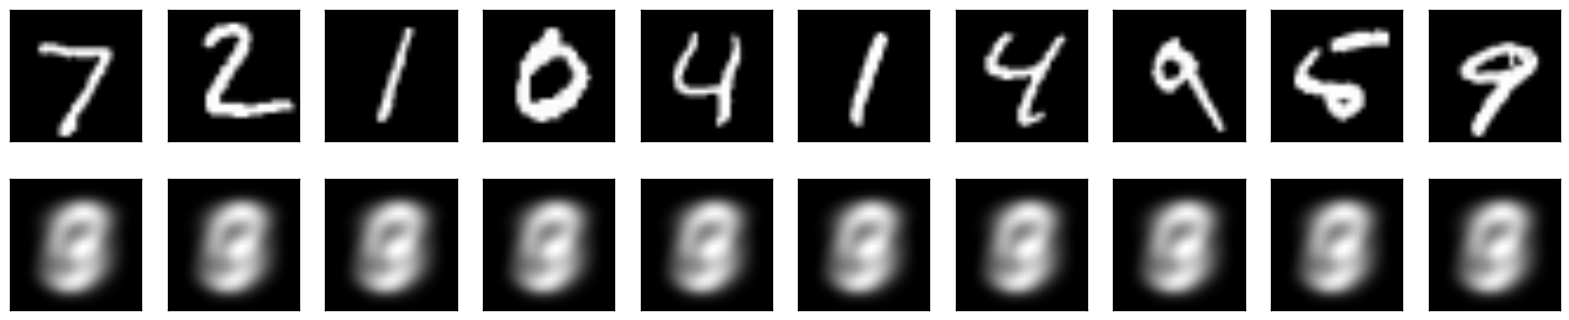

8 Neuronas sigmoid


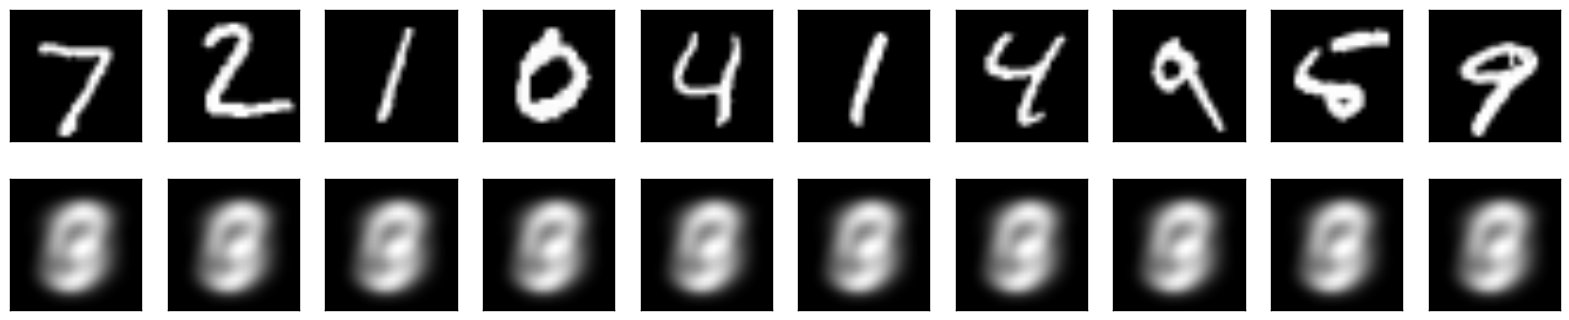

32 Neuronas sigmoid


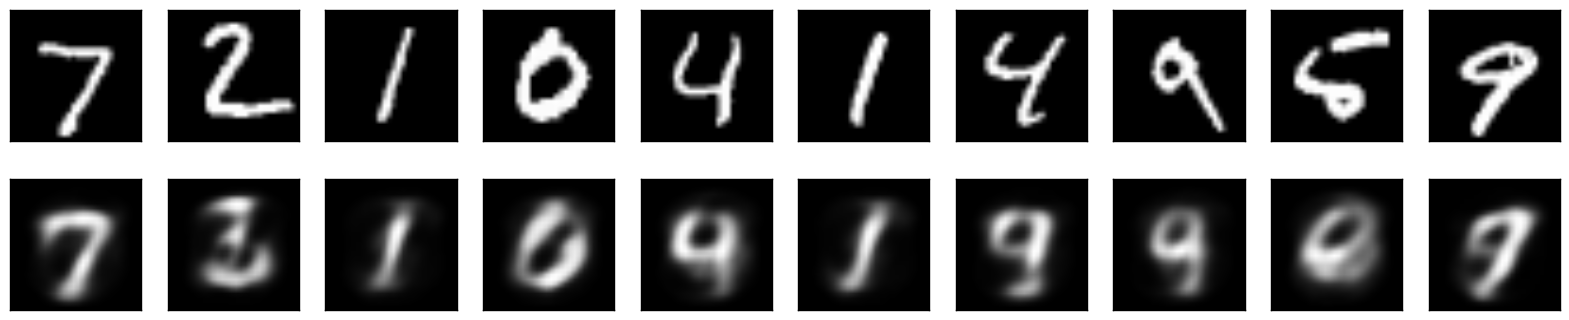

64 Neuronas sigmoid


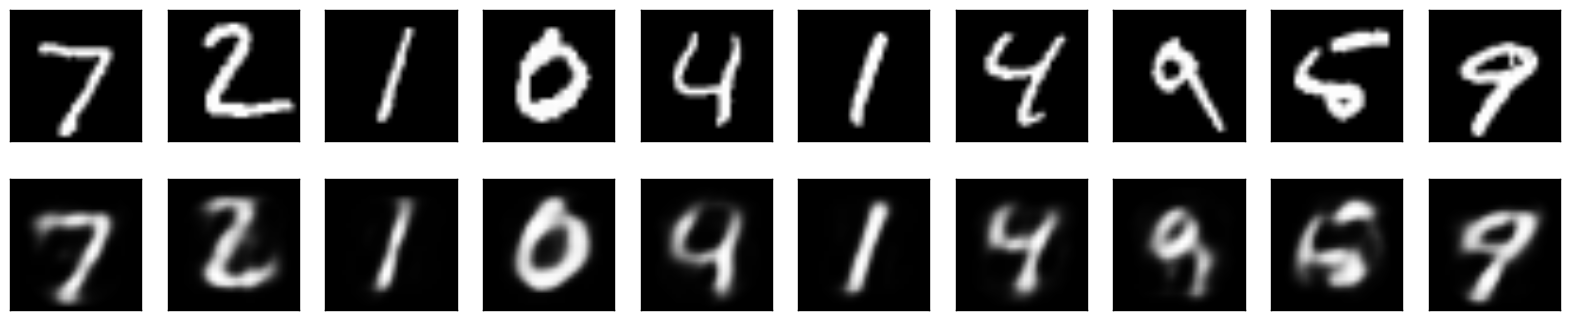

2 Neuronas relu


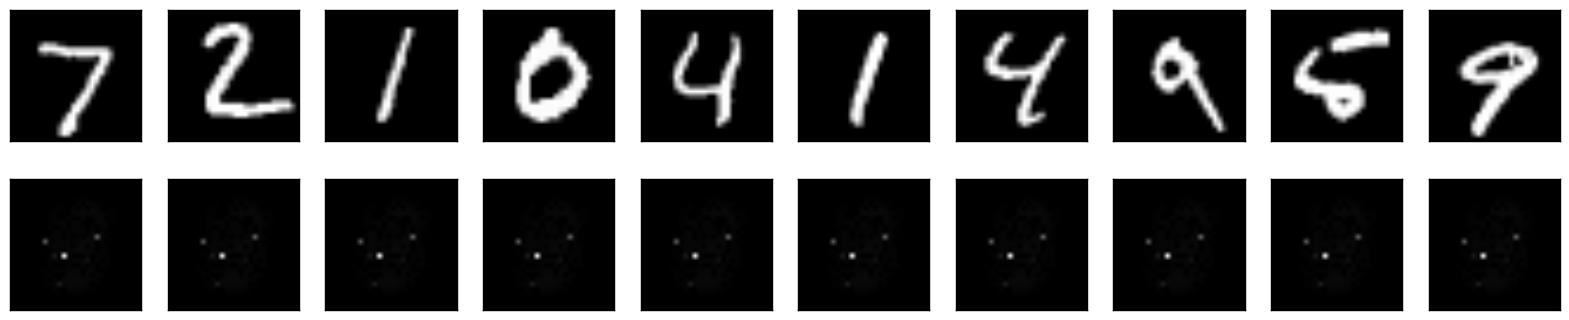

8 Neuronas relu


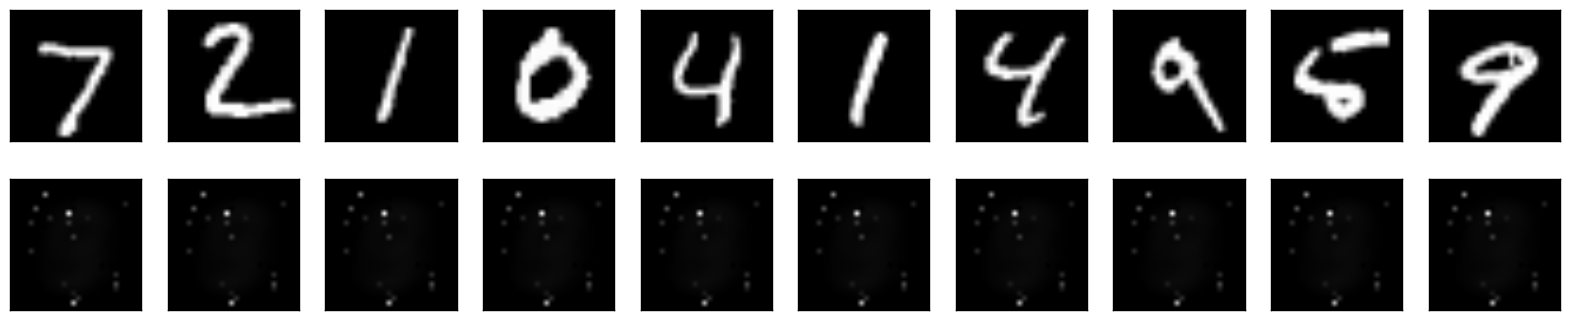

32 Neuronas relu


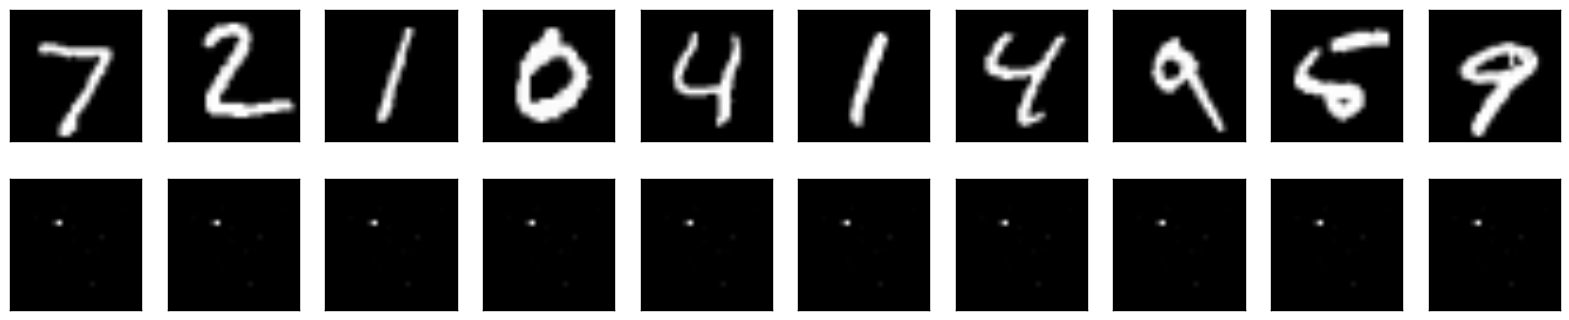

64 Neuronas relu


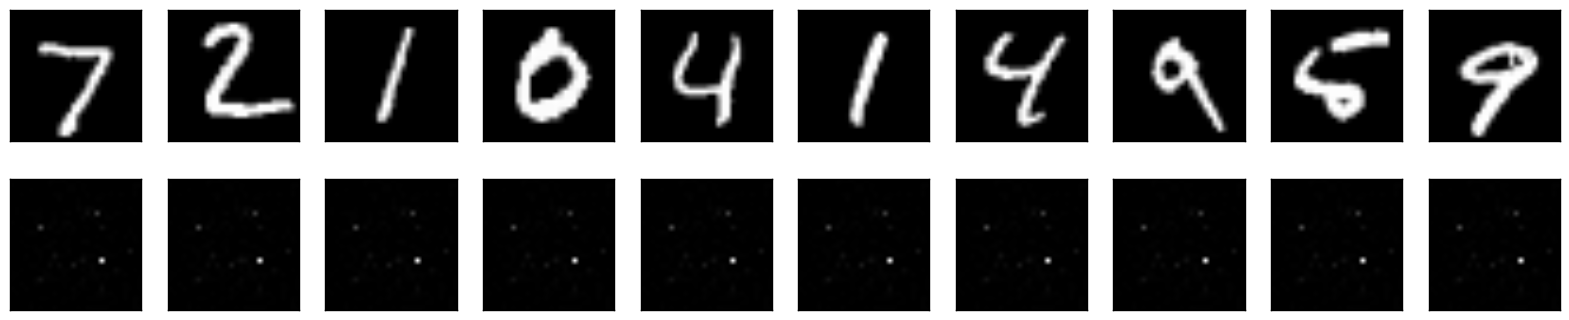

In [6]:
#b
for activ in ["sigmoid","relu"]:
    for size in [2,8,32,64]:
        print "{0} Neuronas {1}".format(size,activ)
        #autoencoder = load_model('basic_autoencoder_sigmoid_768x{0}.h5'.format(size))
        encoder = load_model('encoder_{1}_768x{0}.h5'.format(size,activ))
        decoder = load_model('decoder_{1}_768x{0}.h5'.format(size,activ))
        encoded_test = encoder.predict(x_test)
        decoded_test = decoder.predict(encoded_test)
        #decoded_test = autoencoder.predict(x_test)
        n = 10
        plt.figure(figsize=(20, 4))
        for i in range(n):
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(x_test[i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(decoded_test[i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()

## b
Encontramos que las reconstrucciones hechas con sigmoid tienen mucha relación con el error de reconstruccion calculado anteriormente, mientras que las redes relu no lograron hacer una representación graficamente similar a las originales. A medida que hay más neuronas en la capa de encoder se puede obtener una mayor precisión al reconstruir.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np#c 
for size in [2,8,32,64]:
    #autoencoder = load_model('basic_autoencoder_sigmoid_768x{0}.h5'.format(size))
    encoder = load_model('encoder_sigmoid_768x{0}.h5'.format(size))
    decoder = load_model('decoder_sigmoid_768x{0}.h5'.format(size))
    encoded_train = encoder.predict(x_train)
    encoded_test = encoder.predict(x_test)
    clf = KNeighborsClassifier(10)
    clf.fit(encoded_train, y_train)
    score = clf.score(encoded_test,y_test)
    print "Sigmoid Encoder 768x{0}".format(size)
    print 'Classification Accuracy %.2f' % score

## c
**Valores de precisión de clasificación**
* Sigmoid Encoder 768x2
    * Classification Accuracy 0.18
* Sigmoid Encoder 768x8
    * Classification Accuracy 0.39
* Sigmoid Encoder 768x32
    * Classification Accuracy 0.87
* Sigmoid Encoder 768x64
    * Classification Accuracy 0.96
    
El tiempo aumenta de forma lineal, dado que cada vez que doblamos el numero de neuronas, 2-64, el tiempo se duplica o cuadruplica según sea el caso.

In [ ]:
#d -> para cada modelo obtenido

for size in [2,8,32,64]:
    encoder = load_model('encoder_sigmoid_768x{0}.h5'.format(size))
    decoder = load_model('decoder_sigmoid_768x{0}.h5'.format(size))
    encoded_train = encoder.predict(x_train)
    model = KMeans(n_clusters=10)
    labels_pred = model.fit_predict(encoded_train)
    score = metrics.adjusted_rand_score(y_train, labels_pred)
    print "Sigmoid Encoder 768x{0}".format(size)
    print 'Clustering ARI %.2f' % score
    print 'Clustering ACC %.2f' % clustering_accuracy(labels_pred,y_train)

## d  

* Sigmoid Encoder 768x2
    * Clustering ARI 0.00
    * Clustering ACC 0.12
* Sigmoid Encoder 768x8
    * Clustering ARI 0.00
    * Clustering ACC 0.15
* Sigmoid Encoder 768x32
    * Clustering ARI 0.36
    * Clustering ACC 0.59
* Sigmoid Encoder 768x64
    * Clustering ARI 0.37
    * Clustering ACC 0.59
Nuevamente los valores de clustering, ya sea precisión o ARI, mejoran considerablemente en la medida que se aumenta el número de neuronas centrales. Dado que proveen una representación más rica y por ende facilmente separable.    

In [32]:
#e
for size in [2,8,32,64]:
    print "Components",size
    pca = PCA(n_components=size)
    pca.fit(x_train)
    pca_train = pca.transform(x_train)
    #pca_test = pca.transform(x_test)
    #pca_inverse=pca.inverse_transform(pca_test)
    """ # Ejecutado en momentos distintos por tiempo de ejecución
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(pca_inverse[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    """ 
    #clf = KNeighborsClassifier(10)
    #clf.fit(pca_train, y_train)
    #score = clf.score(pca_test,y_test)
    #print "PCA - {0} Components".format(size)
    #print 'PCA SCORE %.2f' % score
    model = KMeans(n_clusters=10)
    labels_pred = model.fit_predict(pca_train)
    score = metrics.adjusted_rand_score(y_train, labels_pred)
    print "KMeans PCA{0}".format(size)
    print 'Clustering ARI %.2f' % score
    print 'Clustering ACC %.2f' % clustering_accuracy(labels_pred,y_train)

Components 2
KMeans PCA2
Clustering ARI 0.24
Clustering ACC 0.41
Components 8
KMeans PCA8
Clustering ARI 0.35
Clustering ACC 0.59
Components 32
KMeans PCA32
Clustering ARI 0.36
Clustering ACC 0.59
Components 64
KMeans PCA64
Clustering ARI 0.36
Clustering ACC 0.59


## e

| Architecture   | 768x2 | 768x8 | 768x32 | 768x64 |
|----------------|-------|-------|--------|--------|
| Clustering ARI | 0.24  | 0.35  | 0.36   | 0.36   |
| Clustering ACC | 0.41  | 0.59  | 0.59   | 0.59   |
| KNN Score      | 0.44  | 0.90  | 0.94   | 0.97   |

Probando el método de PCA vemos que obtiene resultados muy similares en las últimas etapas (32 y 64 componentes) pero tiene un rendimiento mayor que las redes entrenadas previamente para sus versiones en 2 y 8 componentes. Por lo que nos parece que PCA con un alto numero de componentes es más conveniente que una red neuronal, siendo que un autoencoder hace casi la misma función de encontrar cuales son los elementos más importantes de la representación inicial y así clasificarla.

In [ ]:
#f
##Saving models
"""
for size in [2,8,32,64]:
    print "Components",size
    model = BernoulliRBM(n_components=size, batch_size=25,
        learning_rate=0.05,verbose=1, n_iter=50) ##n_components is d'
    model.fit(x_train)##Train using persistent Gibbs chains
    fileo = open('basicRBM{0}.pickle'.format(size),'wb')
    pickle.dump(model,fileo)
    fileo.close()
"""
#Loading and testing
for size in [2,8,32,64]:
    print "Components",size
    model = pickle.load(open('basicRBM{0}.pickle'.format(size), 'rb'))
    result = model.gibbs(x_train)
    #print "Reconstruction Error: ",ReconError(x_train,result)
    model = KMeans(n_clusters=10)
    labels_pred = model.fit_predict(result)
    score = metrics.adjusted_rand_score(Y_train, labels_pred)
    print "Sigmoid Encoder 768x{0}".format(size)
    print 'Clustering ARI %.2f' % score
    print 'Clustering ACC %.2f' % clustering_accuracy(labels_pred,y_train)
    

## f 
Components 2
Recostruction Error:  10.3257
Components 8
Recostruction Error:  10.532
Components 32
Recostruction Error:  7.63063
Components 64
Recostruction Error:  6.65726

Vemos que el error de reconstruccion con una RBM es menor a medida que aumenta el numero de neuronas que representan los componentes principales o neuronas escondidas del modelos. Entonces se comporta de la misma forma que un AE o post proceso de PCA.

In [8]:
#G
# 2,4,8,16,32
"""
for DIM in [2,8,32,64]:
    target_dim = DIM #try other and do a nice plot ... meh
    input_img = Input(shape=(784,))
    encoded1 = Dense(1000, activation='relu')(input_img)
    encoded2 = Dense(500, activation='relu')(encoded1)
    encoded3 = Dense(250, activation='relu')(encoded2)
    encoded4 = Dense(target_dim, activation='relu')(encoded3)
    decoded4 = Dense(250, activation='relu')(encoded4)
    decoded3 = Dense(500, activation='relu')(encoded3)
    decoded2 = Dense(1000, activation='relu')(decoded3)
    decoded1 = Dense(784, activation='sigmoid')(decoded2)
    autoencoder = Model(input=input_img, output=decoded1)
    encoder = Model(input=input_img, output=encoded3)
    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    autoencoder.fit(x_train,x_train,nb_epoch=50,batch_size=25,shuffle=True,
        validation_data=(x_val, x_val))
    autoencoder.save('my_autoencoder_768x1000x500x250x{0}.h5'.format(target_dim))
    #from sklearn.decomposition import PCA
    #from sklearn.neighbors import KNeighborsClassifier
    #pca = PCA(n_components=target_dim)
    #pca.fit(x_train)
"""
Files=["my_autoencoder_768x1000x500x250x2.h5","my_autoencoder_768x1000x500x250x4.h5","my_autoencoder_768x1000x500x250x8.h5","my_autoencoder_768x1000x500x250x16.h5","my_autoencoder_768x1000x500x250x32.h5",
      "my_autoencoder_768x1000x500x2.h5","my_autoencoder_768x1000x500x4.h5","my_autoencoder_768x1000x500x8.h5","my_autoencoder_768x1000x500x16.h5","my_autoencoder_768x1000x500x32.h5",
      "my_autoencoder_768x1000x2.h5","my_autoencoder_768x1000x4.h5","my_autoencoder_768x1000x8.h5","my_autoencoder_768x1000x16.h5","my_autoencoder_768x1000x32.h5"]
Files2=["my_encoder_768x1000x500x250x2.h5","my_encoder_768x1000x500x250x4.h5","my_encoder_768x1000x500x250x8.h5","my_encoder_768x1000x500x250x16.h5","my_encoder_768x1000x500x250x32.h5",
      "my_encoder_768x1000x500x2.h5","my_encoder_768x1000x500x4.h5","my_encoder_768x1000x500x8.h5","my_encoder_768x1000x500x16.h5","my_encoder_768x1000x500x32.h5",
      "my_encoder_768x1000x2.h5","my_encoder_768x1000x4.h5","my_encoder_768x1000x8.h5","my_encoder_768x1000x16.h5","my_encoder_768x1000x32.h5"]
Tags=["4 Layers 2 Neurons","4 Layers 4 Neurons","4 Layers 8 Neurons","4 Layers 16 Neurons","4 Layers 32 Neurons",
      "3 Layers 2 Neurons","3 Layers 4 Neurons","3 Layers 8 Neurons","3 Layers 16 Neurons","3 Layers 32 Neurons",
      "2 Layers 2 Neurons","2 Layers 4 Neurons","2 Layers 8 Neurons","2 Layers 16 Neurons","2 Layers 32 Neurons"]
for ind in range(len(Files)):
    autoencoder=load_model(Files[ind])
    autoencoded_train = autoencoder.predict(x_train)
    print Tags[ind]
    print ReconError(x_train,autoencoded_train)

"""
for ind in range(len(Files)):
    encoder=load_model(Files2[ind])
    print Tags[ind]
    encoded_train = encoder.predict(x_train)
    model = KMeans(n_clusters=10)
    labels_pred = model.fit_predict(encoded_train)
    score = metrics.adjusted_rand_score(y_train, labels_pred)
    print "Sigmoid Encoder 768x{0}".format(size)
    print 'Clustering ARI %.2f' % score
    print 'Clustering ACC %.2f' % clustering_accuracy(labels_pred,y_train)

for ind in range(len(Files)):
    encoder=load_model(Files2[ind])
    encoded_train = encoder.predict(x_train)
    encoded_test = encoder.predict(x_test)
    print Tags[ind]
    clf = KNeighborsClassifier(10)
    clf.fit(encoded_train, Y_train)
    score = clf.score(encoded_test,Y_test)
    print 'SCORE %.2f' % score
"""

4 Layers 2 Neurons
1.17658
4 Layers 4 Neurons
1.17819
4 Layers 8 Neurons
1.17323
4 Layers 16 Neurons
1.18904
4 Layers 32 Neurons
1.19014
3 Layers 2 Neurons
5.15302
3 Layers 4 Neurons
4.1508
3 Layers 8 Neurons
3.01656
3 Layers 16 Neurons
2.18101
3 Layers 32 Neurons
1.72726
2 Layers 2 Neurons
5.54556
2 Layers 4 Neurons
4.4813
2 Layers 8 Neurons
3.34936
2 Layers 16 Neurons
2.41391
2 Layers 32 Neurons
1.81793


'\nfor ind in range(len(Files)):\n    encoder=load_model(Files2[ind])\n    print Tags[ind]\n    encoded_train = encoder.predict(x_train)\n    model = KMeans(n_clusters=10)\n    labels_pred = model.fit_predict(encoded_train)\n    score = metrics.adjusted_rand_score(y_train, labels_pred)\n    print "Sigmoid Encoder 768x{0}".format(size)\n    print \'Clustering ARI %.2f\' % score\n    print \'Clustering ACC %.2f\' % clustering_accuracy(labels_pred,y_train)\n\nfor ind in range(len(Files)):\n    encoder=load_model(Files2[ind])\n    encoded_train = encoder.predict(x_train)\n    encoded_test = encoder.predict(x_test)\n    print Tags[ind]\n    clf = KNeighborsClassifier(10)\n    clf.fit(encoded_train, Y_train)\n    score = clf.score(encoded_test,Y_test)\n    print \'SCORE %.2f\' % score\n'

## g Resultados de Errores con AutoEncoder de Varias capas y varias neuronas de encoding

|  Layers-Encoding N.  | 4-2 | 4-4 | 4-8 | 4-16 | 4-32 | 3-2 | 3-4 | 3-8 | 3-16 | 3-32 | 2-2 | 2-4 | 2-8 | 2-16 | 2-32 |
|:--------------------:|-----|-----|-----|------|------|-----|-----|-----|------|------|-----|-----|-----|------|------|
| Reconstruction Error |1.17|1.17|1.17|1.18|1.19|5.15|4.15|3.01|2.18|1.72|5.54|4.48|3.34|2.41|1.81|
| Clustering ARI       |0.36|0.38|0.38|0.37|0.37|0.32|0.34|0.35|0.48|0.35|0.20|0.33|0.42|0.46|0.31|
| Clustering Accuracy  |0.57|0.60|0.59|0.59|0.59|0.48|0.55|0.54|0.66|0.56|0.45|0.51|0.62|0.64|0.54|
| KNN-Score            |0.96|0.96|0.96|0.96|0.96|0.73|0.89|0.95|0.96|0.97|0.56|0.85|0.93|0.96|0.96|


Podemos darnos cuenta que los modelos con más precisión son los que tienen más capas y de forma local entre cada modelo con menos capas los mejores son los que tienen más neuronas en su capa de encoder. Vemos que estos resultados son lógicos y esperados en base a los entrenamientos previos dado que a mayor cantidad de capas podemos obtener una version sintetizada de los parametros representativos del input y tener una versión comprimida de mayor fidelidad en la capa central, esto se nota mucho en los buenos resultados de la red de 4 capas y 2 neuronas de encoder que tras una arquitectura de 768x1000x500x250x2 obtiene muy buenos resultados pese a su contraparte 768x2 de la parte inicial.

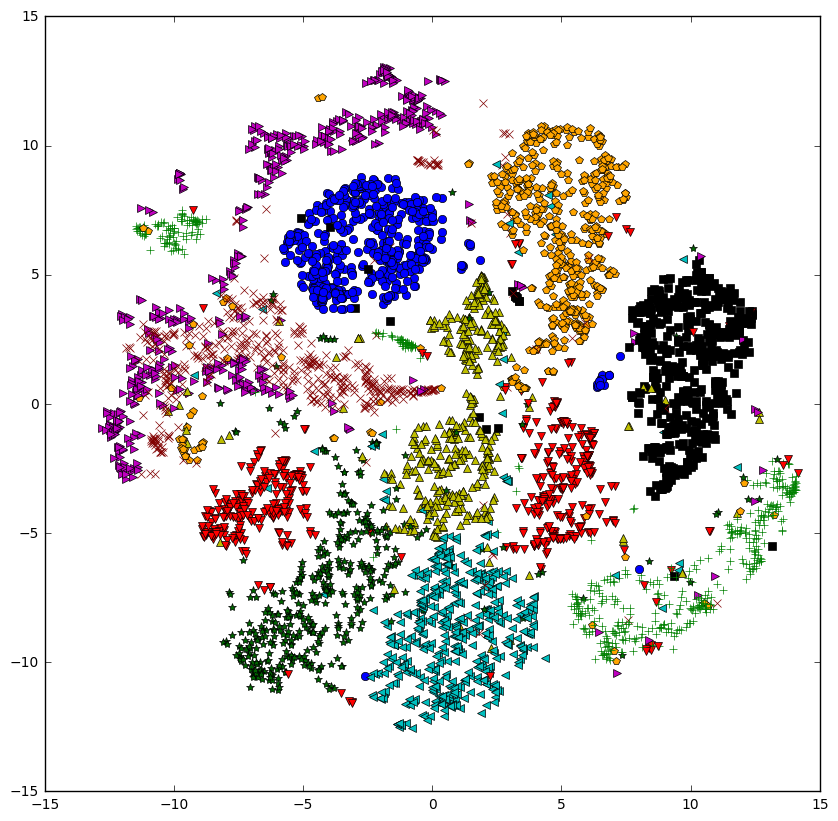

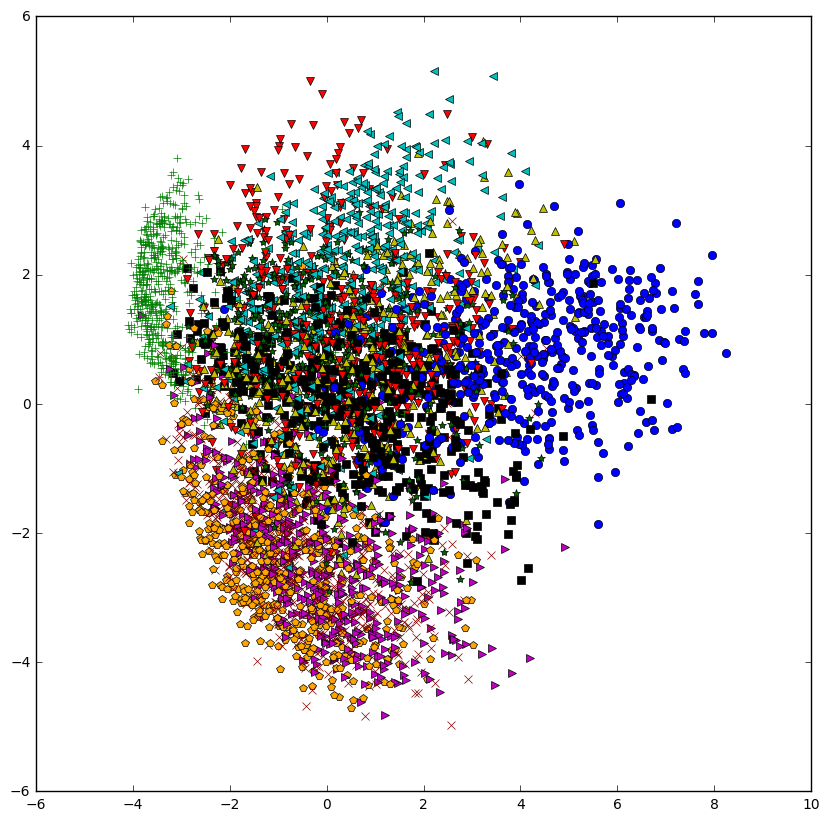

In [21]:
#h
nplot=5000 #warning: mind your memory!
encoder=load_model("my_autoencoder_768x1000x500x250x2.h5")
encoded_train = encoder.predict(x_train[:nplot])
model = TSNE(n_components=2, random_state=0)
encoded_train = model.fit_transform(encoded_train)
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
plt.figure(figsize=(10, 10))
for idx in xrange(0,nplot):
    label = y_train[idx]
    line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
        color=colors[label], marker=markers[label], markersize=6)
pca = PCA(n_components=2)
pca.fit(x_train)
pca_train = pca.transform(x_train)
encoded_train = pca_train[:nplot]
plt.figure(figsize=(10, 10))
for idx in xrange(0,nplot):
    label = y_train[idx]
    line = plt.plot(pca_train[idx][0],pca_train[idx][1],
        color=colors[label], marker=markers[label], markersize=6)
plt.show()


Graficando las etiquetas y los valores de representación en la capa de codificación de dimensión 2 nos damos cuenta que la representación de la red 784x1000x500x250x2 es bastante más diferenciable y agrupable que su contraparte PCA de 2 componentes, por tanto la clasificación está menos propensa a errores pese a que existen areas compartidas entre etiquetas.

##  i,j) 


# 1.2 Denoising

In [13]:
#a
noise_level = 0.1
noise_mask = binomial(n=1,p=noise_level,size=x_train.shape)
noisy_x_train = x_train*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_val.shape)
noisy_x_val = x_val*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_test.shape)
noisy_x_test = x_test*noise_mask

Masking Noise Level 0.1


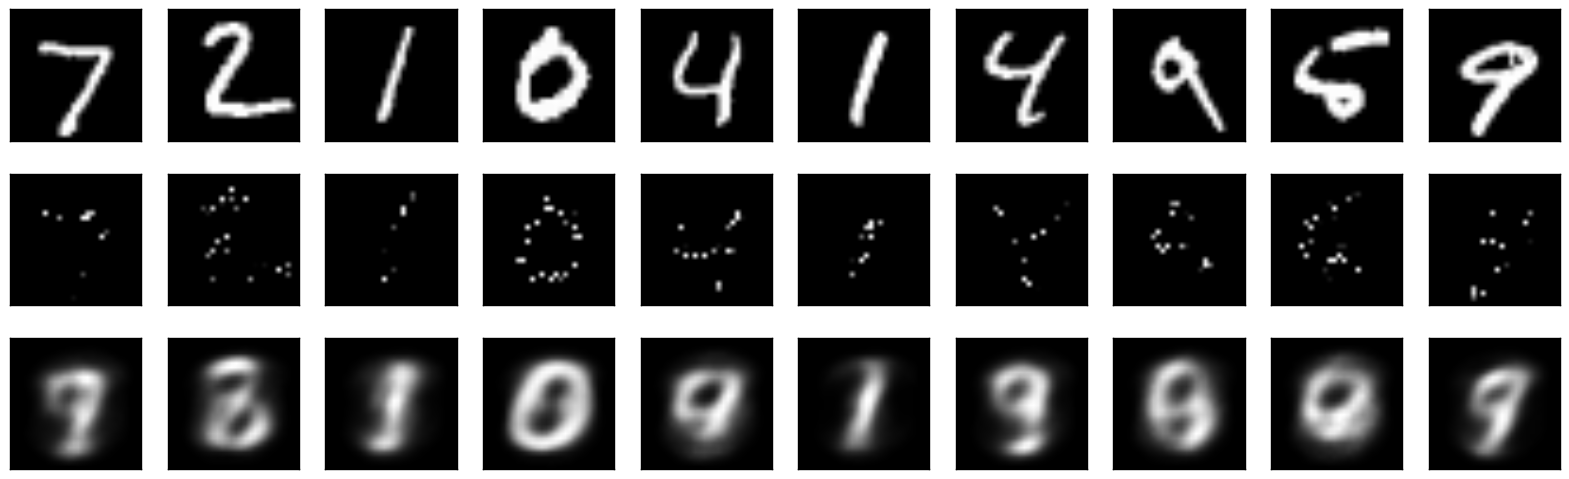

Masking Noise Level 0.2


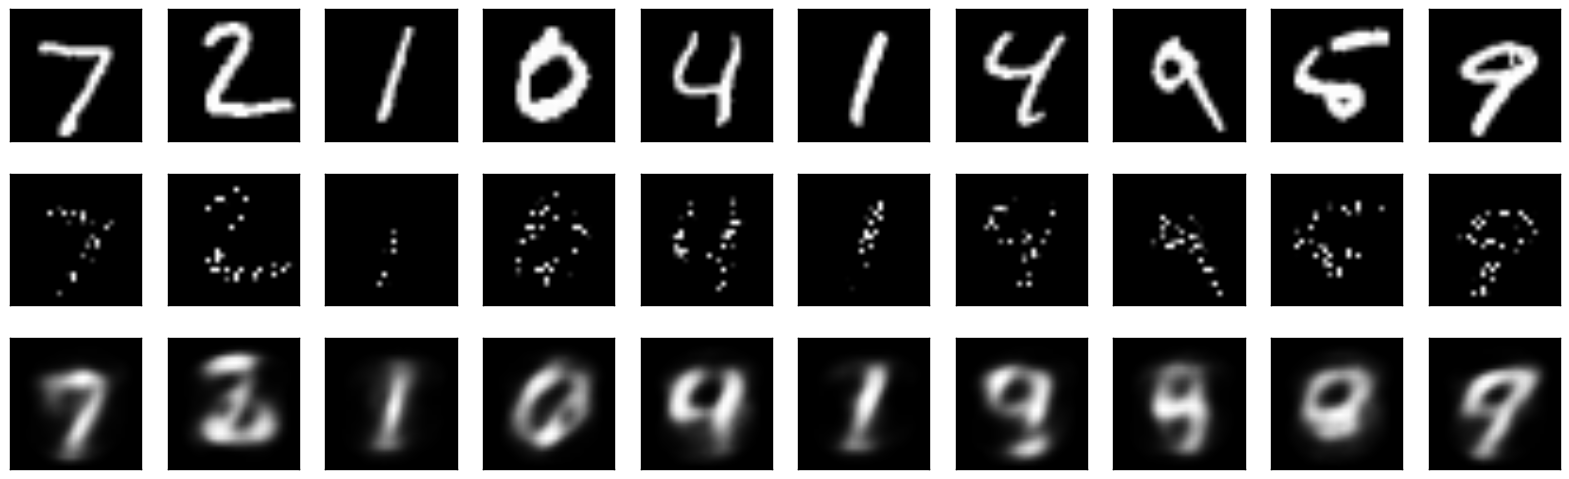

Masking Noise Level 0.4


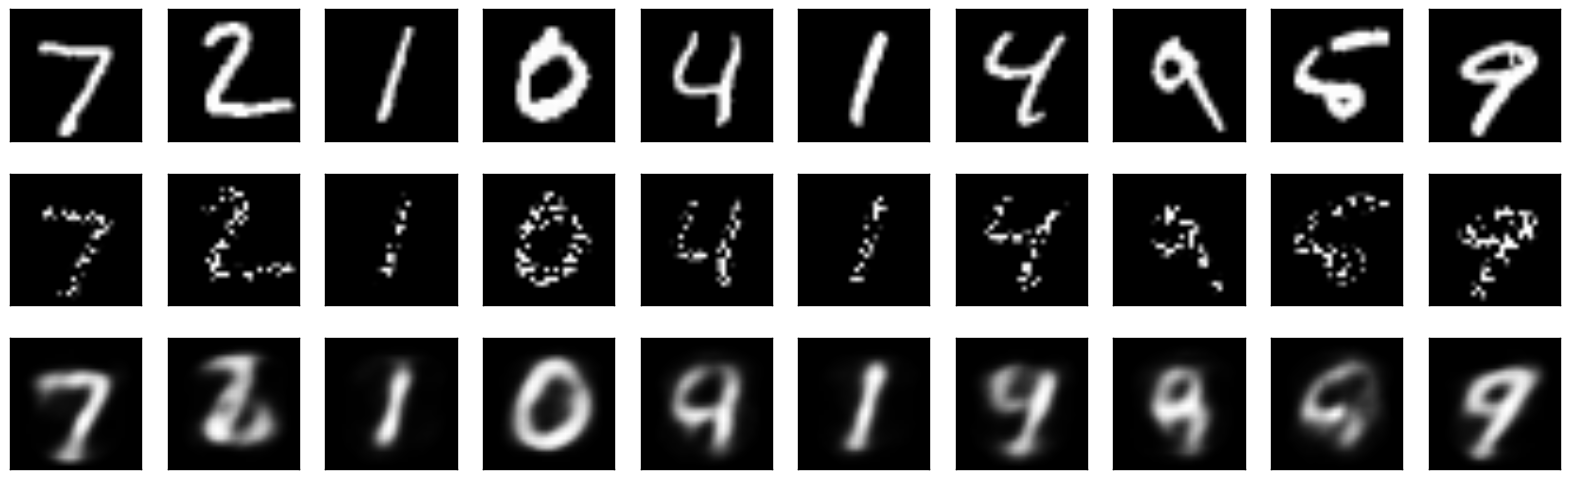

Masking Noise Level 0.6


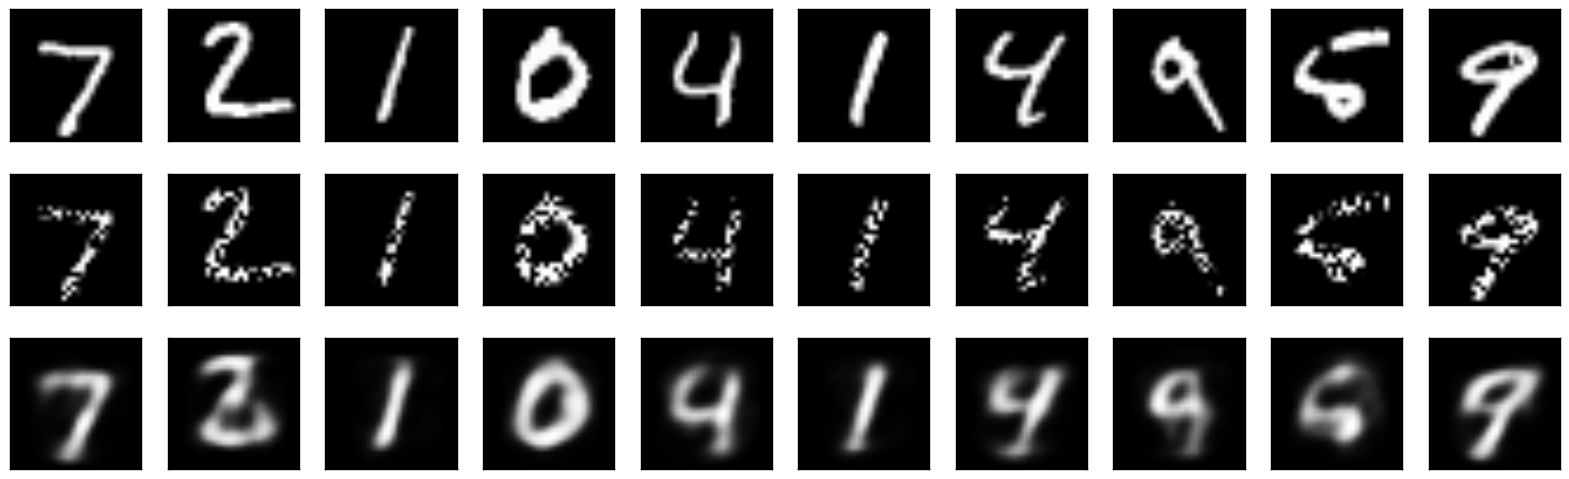

Masking Noise Level 0.8


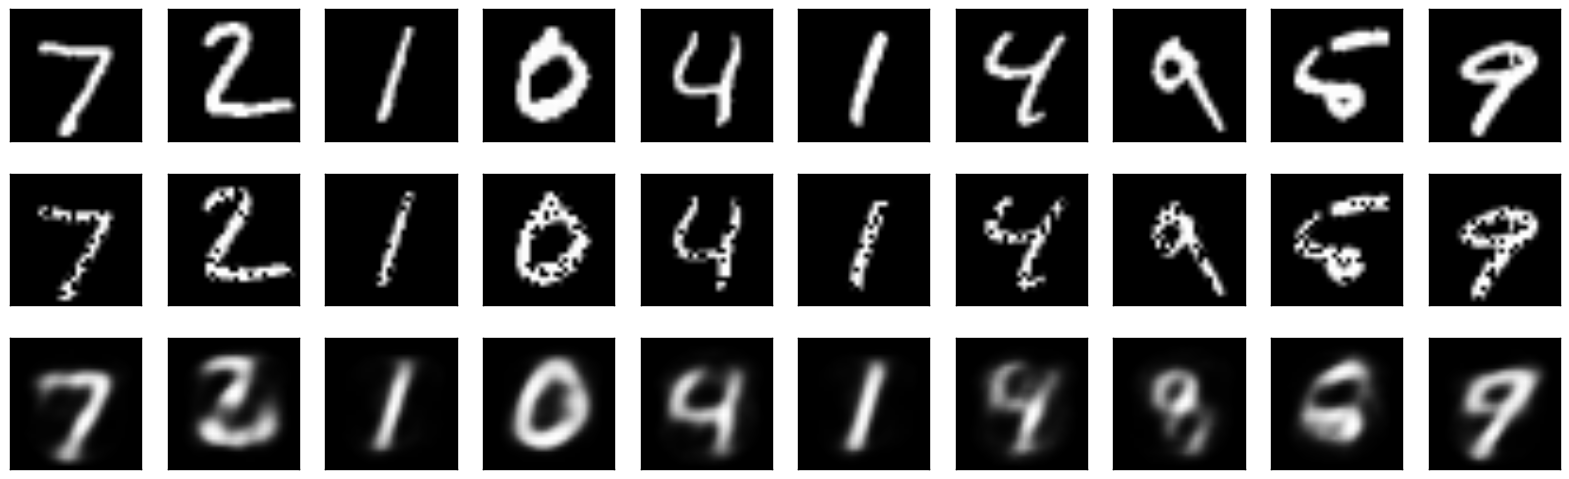

In [4]:
#b
"""
for level in [10,20,40,60,80]:
    noise_level = level/100.0
    noise_mask = binomial(n=1,p=noise_level,size=x_train.shape)
    noisy_x_train = x_train*noise_mask
    noise_mask = binomial(n=1,p=noise_level,size=x_val.shape)
    noisy_x_val = x_val*noise_mask
    noise_mask = binomial(n=1,p=noise_level,size=x_test.shape)
    noisy_x_test = x_test*noise_mask
    input_img = Input(shape=(784,))
    encoded = Dense(64, activation="sigmoid")(input_img)
    decoded = Dense(784, activation="sigmoid")(encoded)
    autoencoder = Model(input=input_img, output=decoded)
    encoder = Model(input=input_img, output=encoded)
    encoded_input = Input(shape=(64,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    autoencoder.fit(noisy_x_train, x_train, nb_epoch=50, batch_size=50,
                    shuffle=True, validation_data=(noisy_x_val, x_val),verbose=1)
    autoencoder.save("noisemask{0}_autoencoder_sig_768x64".format(level))
    encoder.save('noisemask{0}_encoder_sig_768x64.h5'.format(level))
"""
for level in [10,20,40,60,80]:
    noise_level = level/100.0
    noise_level = level/100.0
    noise_mask = binomial(n=1,p=noise_level,size=x_train.shape)
    noisy_x_train = x_train*noise_mask
    noise_mask = binomial(n=1,p=noise_level,size=x_val.shape)
    noisy_x_val = x_val*noise_mask
    noise_mask = binomial(n=1,p=noise_level,size=x_test.shape)
    noisy_x_test = x_test*noise_mask
    print "Masking Noise Level",noise_level
    autoencoder=load_model("noisemask{0}_autoencoder_sig_768x64.h5".format(level))
    decoded_test=autoencoder.predict(noisy_x_test)
    n = 10
    plt.figure(figsize=(20, 6))
    for i in range(n):
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(noisy_x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(decoded_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


In [26]:
#c
devst = 0.50
noise_mask = devst*standard_normal(size=x_train.shape)
noisy_x_train = x_train*noise_mask
noise_mask = devst*standard_normal(size=x_val.shape)
noisy_x_val = x_val*noise_mask
noise_mask = devst*standard_normal(size=x_test.shape)
noisy_x_test = x_test*noise_mask

Noise 0.25


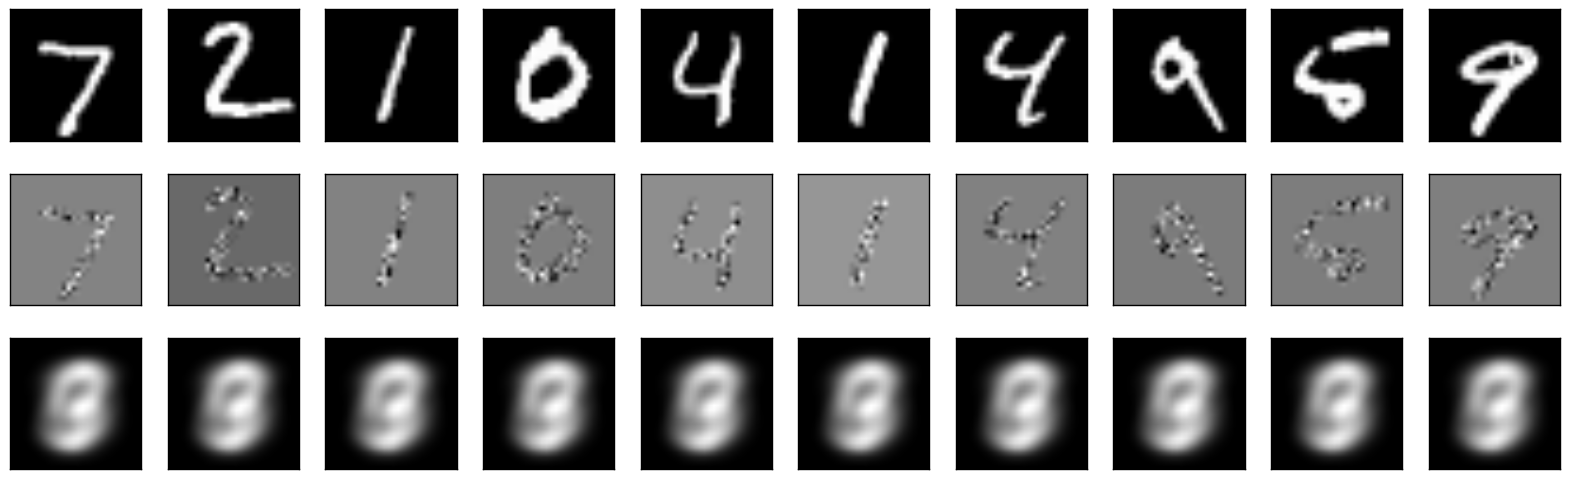

Noise 0.5


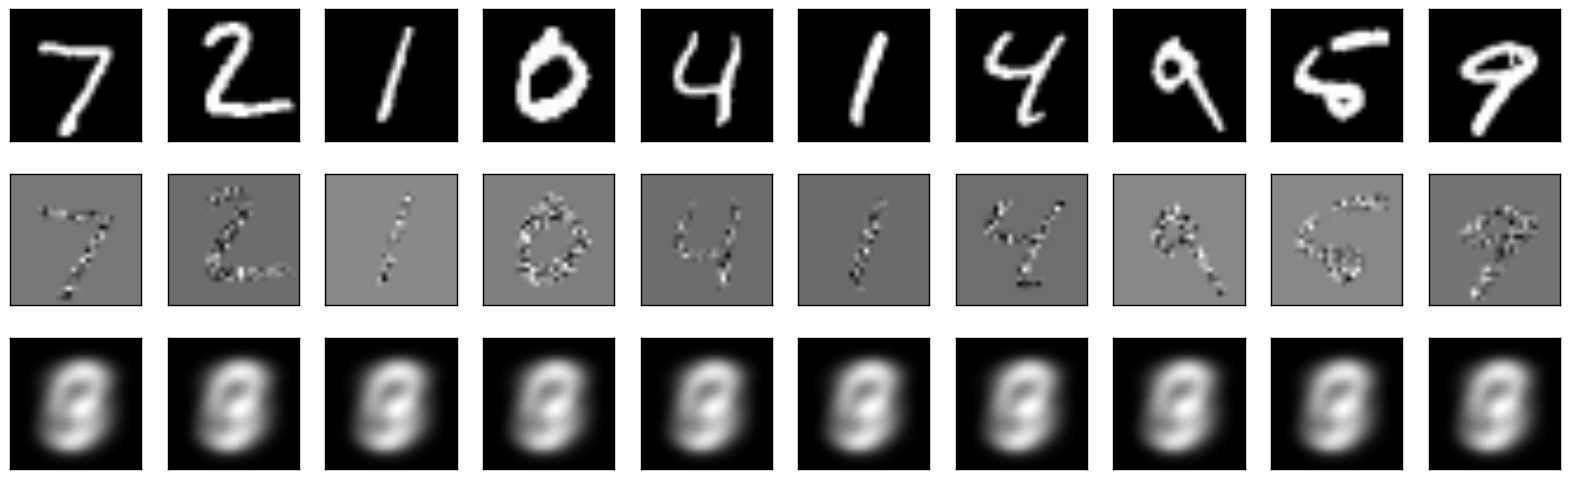

Noise 0.75


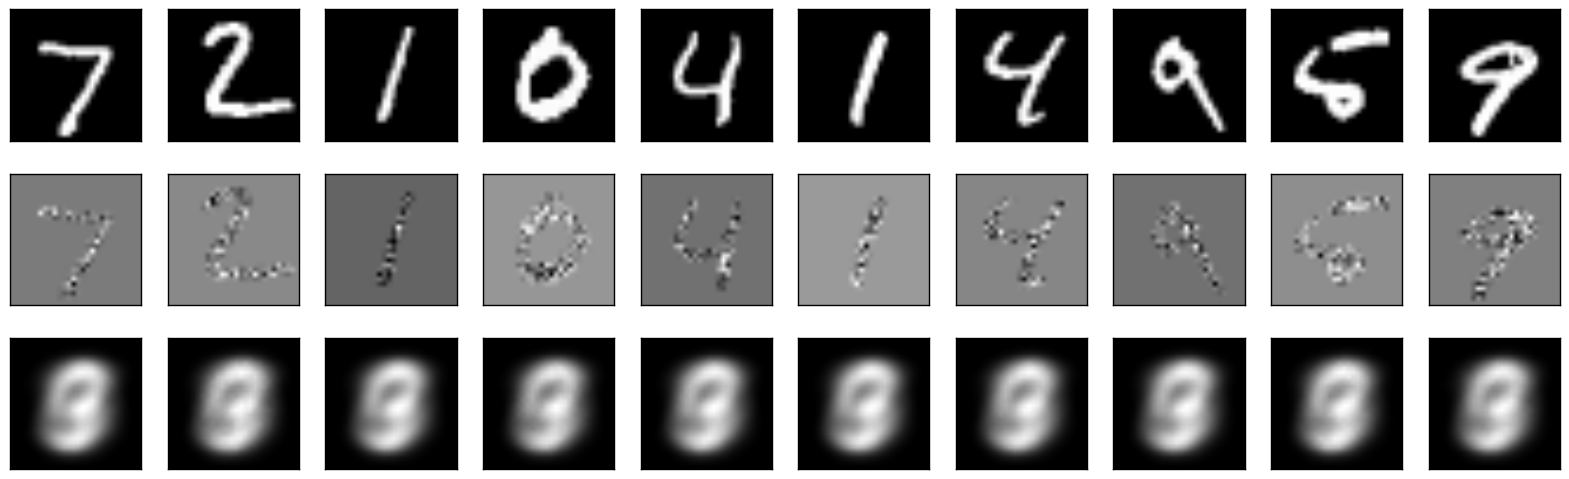

In [3]:
"""
for NOISE in [25,50,75]:
    devst = NOISE/100.0
    noise_mask = devst*standard_normal(size=x_train.shape)
    noisy_x_train = x_train*noise_mask
    noise_mask = devst*standard_normal(size=x_val.shape)
    noisy_x_val = x_val*noise_mask
    noise_mask = devst*standard_normal(size=x_test.shape)
    noisy_x_test = x_test*noise_mask
    input_img = Input(shape=(784,))
    encoded = Dense(64, activation="sigmoid")(input_img)
    decoded = Dense(784, activation="sigmoid")(encoded)
    autoencoder = Model(input=input_img, output=decoded)
    encoder = Model(input=input_img, output=encoded)
    encoded_input = Input(shape=(64,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    autoencoder.fit(noisy_x_train, x_train, nb_epoch=50, batch_size=50,
                    shuffle=True, validation_data=(noisy_x_val, x_val),verbose=1)
    autoencoder.save("noisegauss{0}_autoencoder_sig_768x64.h5".format(NOISE))
    encoder.save('noisegauss{0}_encoder_sig_768x64.h5'.format(NOISE))
"""
for NOISE in [25,50,75]:
    devst = NOISE/100.0
    noise_mask = devst*standard_normal(size=x_train.shape)
    noisy_x_train = x_train*noise_mask
    noise_mask = devst*standard_normal(size=x_val.shape)
    noisy_x_val = x_val*noise_mask
    noise_mask = devst*standard_normal(size=x_test.shape)
    noisy_x_test = x_test*noise_mask
    autoencoder=load_model('noisegauss{0}_autoencoder_sig_768x64.h5'.format(NOISE))
    print "Noise {0}".format(devst)
    decoded_test=autoencoder.predict(noisy_x_test)
    n = 10
    plt.figure(figsize=(20, 6))
    for i in range(n):
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(noisy_x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(decoded_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


# 1.3 Pre-entrenamiento
## a) Precisión de una Sigmoidal-FFN 768x1000x1000x10

In [ ]:
n_hidden_layer1 = 1000
activation_layer1 = 'sigmoid'
decoder_activation_1 = 'sigmoid'
n_hidden_layer2 = 1000
activation_layer1 = 'sigmoid'
decoder_activation_2 = 'sigmoid'
loss_ = 'binary_crossentropy'
optimizer_ = SGD(lr=1.0)
epochs_ = 50; batch_size_ = 25


model = Sequential()
model.add(Dense(n_hidden_layer1, activation=activation_layer1, input_shape=(784,)))
model.add(Dense(n_hidden_layer2, activation=activation_layer2))
model.add(Dense(10, activation='softmax'))
model.summary()

model.compile(optimizer=optimizer_,loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, Y_train,nb_epoch=50, batch_size=25,
shuffle=True, validation_data=(x_val, Y_val))
model.save('SigmoidNet-768x1000x1000x10-NFT-50epochs.h5') 

In [11]:
model=load_model("SigmoidNet-768x1000x1000x10-NFT-50epochs.h5")
results=model.evaluate(x_test,Y_test)
print "\nAccuracy: {0}%".format(round(results[1],4)*100)

10000/10000 [==============================] - 0s     

Accuracy: 81.96%


Encontramos una precisión buena en el testing set, con las configuraciones entregadas de 50 epoch, y una arquitectura de 784x1000x1000x10. Y procederemos a pre-entrenarla con AE's.

## b) Utilizando pre-entrenamiento 

In [ ]:
#b
# MODELOS GUARDADOS

###AUTOENCODER 1
input_img1 = Input(shape=(784,))
encoded1 = Dense(n_hidden_layer1,activation=activation_layer1)(input_img1)
decoded1 = Dense(784, activation=decoder_activation_1)(encoded1)
autoencoder1 = Model(input=input_img1, output=decoded1)
encoder1 = Model(input=input_img1, output=encoded1)
autoencoder1.compile(optimizer=optimizer_, loss=loss_)
autoencoder1.fit(x_train, x_train, nb_epoch=epochs_, batch_size=batch_size_,
shuffle=True, validation_data=(x_val, x_val))
encoded_input1 = Input(shape=(n_hidden_layer1,))
autoencoder1.save('autoencoder_layer1.h5')
encoder1.save('encoder_layer1.h5')

###AUTOENCODER 2
x_train_encoded1 = encoder1.predict(x_train) #FORWARD PASS DATA THROUGH FIRST ENCODER
x_val_encoded1 = encoder1.predict(x_val)
x_test_encoded1 = encoder1.predict(x_test)

input_img2 = Input(shape=(n_hidden_layer1,))
encoded2 = Dense(n_hidden_layer2, activation=activation_layer2)(input_img2)
decoded2 = Dense(n_hidden_layer2, activation=decoder_activation_2)(encoded2)
autoencoder2 = Model(input=input_img2, output=decoded2)
encoder2 = Model(input=input_img2, output=encoded2)
autoencoder2.compile(optimizer=optimizer_, loss=loss_)
autoencoder2.fit(x_train_encoded1,x_train_encoded1,nb_epoch=epochs_,batch_size=batch_size_,
shuffle=True, validation_data=(x_val_encoded1, x_val_encoded1))
encoded_input2 = Input(shape=(n_hidden_layer2,))
autoencoder2.save('autoencoder_layer2.h5')
encoder2.save('encoder_layer2.h5')

#FINE TUNNING

model = Sequential()
model.add(Dense(n_hidden_layer1, activation=activation_layer1, input_shape=(784,)))
model.layers[-1].set_weights(autoencoder1.layers[1].get_weights())
model.add(Dense(n_hidden_layer2, activation=activation_layer2))
model.layers[-1].set_weights(autoencoder2.layers[1].get_weights())
model.add(Dense(10, activation='softmax'))
model.summary()
model.compile(optimizer=optimizer_,loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, Y_train,nb_epoch=20, batch_size=25,
shuffle=True, validation_data=(x_val, Y_val))
model.save('SigmoidNet-768x1000x1000x10-finetunned.h5')


In [12]:
model=load_model('SigmoidNet-768x1000x1000x10-finetunned.h5')
results=model.evaluate(x_test,Y_test)
print "\nAccuracy: {0}%".format(round(results[1],4)*100)

IOError: Unable to open file (Unable to open file: name = 'sigmoidnet-768x1000x1000x10-finetunned.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

Lamentablemente vemos que el rendimiento de una red con fine-tunning osea, pre-entrenada mediante AE  de forma AE > AE > FF. No tiene un rendimiento tan bueno como la red original de parte **a** por lo tanto creemos que la red puede haberse excedido en entrenamiento y caído en overfitting.

## c) Pre-entrenamiento con RBM

In [ ]:
#c
rbm1 = BernoulliRBM(n_components=n_hidden_layer1, batch_size=25,
learning_rate=0.05,verbose=1, n_iter=50)
rbm1.fit(x_train)##Train using persistent Gibbs chains
encoded_train1 = rbm1.transform(x_train)
encoded_val1 = rbm1.transform(x_val)
encoded_test1 = rbm1.transform(x_test)
fileo = open('noiseRBM1.pickle','wb')
pickle.dump(rbm1,fileo)
fileo.close()


rbm2 = BernoulliRBM(n_components=n_hidden_layer2, batch_size=25,
learning_rate=0.05,verbose=1, n_iter=50)
rbm2.fit(encoded_train1)
encoded_train2 = rbm2.transform(encoded_train1)
encoded_val2 = rbm2.transform(encoded_val1)
encoded_test2 = rbm2.transform(encoded_test1)
fileo = open('noiseRBM2.pickle','wb')
pickle.dump(rbm2,fileo)
fileo.close()

## d) Pre-entrenamiento con dAE
> **NOTA**: Tenemos todos los modelos previamente entrenados y guardados, tanto como los dAE de esta sección y los 
> AE de la siguiente. por ende solo cargamos las redes pre-entrenadas.

In [18]:
model2=load_model('noise_SigmoidNet-768x1000x1000x10-finetunned.h5')
#model2.summary
results=model2.evaluate(x_test,Y_test)
print "\nAccuracy: {0}%".format(round(results[1],4)*100)

Exception: Optimizer weight shape (784, 1000) not compatible with provided weight shape (1000, 10)

## f) Con Tanh y Relu

In [21]:
print "Tanh sin pre-entrenamiento"
model=load_model('TanhNet-768x1000x1000x10-NFT-50epochs.h5')
results=model.evaluate(x_test,Y_test)
print "\nAccuracy: {0}%".format(round(results[1],4)*100)
print "Tanh con pre-entrenamiento"
model=load_model('TanhNet-768x1000x1000x10-finetunned.h5')
results=model.evaluate(x_test,Y_test)
print "\nAccuracy: {0}%".format(round(results[1],4)*100)

print "Relu sin pre-entrenamiento"
model=load_model('ReluNet-768x1000x1000x10-NFT-50epochs.h5')
results=model.evaluate(x_test,Y_test)
print "\nAccuracy: {0}%".format(round(results[1],4)*100)
print "Relu con pre-entrenamiento"
model=load_model('ReluNet-768x1000x1000x10-finetunned.h5')
results=model.evaluate(x_test,Y_test)
print "\nAccuracy: {0}%".format(round(results[1],4)*100)

Tanh sin pre-entrenamiento
10000/10000 [==============================] - 0s     

Accuracy: 99.68%
Tanh con pre-entrenamiento
 9920/10000 [============================>.] - ETA: 0s
Accuracy: 82.06%
Relu sin pre-entrenamiento
 9952/10000 [============================>.] - ETA: 0s
Accuracy: 99.72%
Relu con pre-entrenamiento
 9984/10000 [============================>.] - ETA: 0s
Accuracy: 81.95%


Notamos que los resultados de las redes con funciones de activación tanh y relu sin pre-entrenar tienen muy buenos resultados a diferencia de la version con finetunning con los AE es probable que esto ocurra debido a overfitting

## g) Cambios de numero de neuronas 500,1000,2000,3000

> Errores al concatenar modelos por potencial diferencia de versiones de keras (Labcomp y nuestros pc)
> https://github.com/fchollet/keras/issues/4044

In [33]:
print "Sigmoid 500 sin pre-entrenamiento"
model=load_model('SigmoidNet-768x500x500x10-NFT-50epochs.h5')
results=model.evaluate(x_test,Y_test)
print "\nAccuracy: {0}%".format(round(results[1],4)*100)
print "Sigmoid 500 con pre-entrenamiento"
print "Error de modelo - Sin resultados"

print "Sigmoid 1000 sin pre-entrenamiento"
model=load_model('SigmoidNet-768x1000x1000x10-NFT-50epochs.h5')
results=model.evaluate(x_test,Y_test)
print "\nAccuracy: {0}%".format(round(results[1],4)*100)
print "Sigmoid 1000 con pre-entrenamiento"
#model=load_model('SigmoidNet-768x500x500x10-finetunned.h5')
print "Error de modelo - Sin resultados"

print "Sigmoid 2000 sin pre-entrenamiento"
model=load_model('SigmoidNet-768x2000x2000x10-NFT-50epochs.h5')
results=model.evaluate(x_test,Y_test)
print "\nAccuracy: {0}%".format(round(results[1],4)*100)
print "Sigmoid 2000 con pre-entrenamiento"
print "Error de modelo - Sin resultados"
#model=load_model('SigmoidNet-768x500x500x10-finetunned.h5')
#results=model.evaluate(x_test,Y_test)
#print "\nAccuracy: {0}%".format(round(results[1],4)*100)
print "Sigmoid 3000 sin pre-entrenamiento"
model=load_model('SigmoidNet-768x3000x3000x10-NFT-50epochs.h5')
results=model.evaluate(x_test,Y_test)
print "\nAccuracy: {0}%".format(round(results[1],4)*100)
print "Sigmoid 3000 con pre-entrenamiento"
print "Error de modelo - Sin resultados"
#model=load_model('SigmoidNet-768x3000x3000x10-finetunned.h5')
#results=model.evaluate(x_test,Y_test)
#print "\nAccuracy: {0}%".format(round(results[1],4)*100)

Sigmoid 500 sin pre-entrenamiento
 9952/10000 [============================>.] - ETA: 0s
Accuracy: 99.61%
Sigmoid 500 con pre-entrenamiento
Error de modelo - Sin resultados
Sigmoid 1000 sin pre-entrenamiento
10000/10000 [==============================] - 0s     

Accuracy: 81.96%
Sigmoid 1000 con pre-entrenamiento
Error de modelo - Sin resultados
Sigmoid 2000 sin pre-entrenamiento
10000/10000 [==============================] - 1s     

Accuracy: 81.96%
Sigmoid 2000 con pre-entrenamiento
Error de modelo - Sin resultados
Sigmoid 3000 sin pre-entrenamiento
10000/10000 [==============================] - 3s     

Accuracy: 81.78%
Sigmoid 3000 con pre-entrenamiento
Error de modelo - Sin resultados


# 2 Dataset NORB

> **NOTA:** Utilizamos hasta el bach 8 por que no nos alcanzaba la memoria RAM.

In [1]:
import cPickle
import pickle
from sklearn.neural_network import BernoulliRBM
from numpy.random import binomial,standard_normal
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model,load_model,Sequential
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import scale
def unpickle(file):
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

Using Theano backend.
Using gpu device 0: GeForce 710M (CNMeM is disabled, cuDNN not available)


In [3]:
def load_NORB_train_val(PATH):
    xtr = []
    ytr = []
    xval = []
    yval = []
    for b in range(1,9):
        print b
        f = os.path.join(PATH, 'data_batch_%d' % (b, ))
        datadict = unpickle(f)
        X = datadict['data'].T
        Y = np.array(datadict['labels'])
        Z = np.column_stack((X,Y))
        np.random.shuffle(Z)
        xtr.append(Z[5832:,0:-1])
        ytr.append(Z[5832:,-1])
        xval.append(Z[:5832,0:-1])
        yval.append(Z[:5832,-1])
    Xtr = np.concatenate(xtr)
    del xtr
    Ytr = np.concatenate(ytr)
    del ytr
    Xval = np.concatenate(xval)input
    del Xval
    Yval = np.concatenate(yval)
    del Yval
    return Xtr, Ytr, Xval, Yval

def load_norb_test(PATH):
    xte=[]
    yte=[]
    f = os.path.join(PATH, 'data_batch_%d' % (12, ))
    datadict = unpickle(f)
    X = datadict['data'].T
    Y = np.array(datadict['labels'])
    Z = np.column_stack((X,Y))
    np.random.shuffle(Z)
    xte.append(Z[:,0:-1])
    yte.append(Z[:,-1])
    Xte = np.concatenate(xte)
    del xte
    Yte = np.concatenate(yte)
    del yte
    return Xte,Yte



In [ ]:
Xtr, Ytr, Xval, Yval=load_NORB_train_val('norb')

Xtr=np.float(Xtr);Xval=np.float(Xval)
Ytr=to_categorical(Ytr)
Yval=to_categorical(Yval)
#Asignar media 0 y std 1
Xtr=scale(Xtr)
Xval=scale(Xval)

In [13]:
#Crear y Guardar modelos 
for s_factor in range(1,10):
    s_factor/=10.0
    s_lim=len(Xtr)*s_factor
    print s_factor
    Xstr=Xtr[:s_lim]
    Ystr=Ytr[:s_lim]
    model = Sequential()
    model.add(Dense(4000, activation="relu", input_shape=(2048,)))
    model.add(Dense(2000, activation="relu"))
    model.add(Dense(6, activation='softmax'))
    model.summary()
    model.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['accuracy'])
    model.fit(Xstr, Ystr, batch_size=10, nb_epoch=10, verbose=1,validation_data=(Xval, Yval))
    model.save("2-Relu-4000x2000x10-{0}.h".format(s_factor))


In [5]:
Xte,Yte=load_norb_test("norb")
Yte=to_categorical(Yte)
model=load_model("2-Relu-4000x2000x10-0.1.h")
score=model.evaluate(Xte,Yte)
print "Model Accuracy (0.1) : {0}".format(score[1])
model=load_model("2-Relu-4000x2000x10-0.2.h")
score=model.evaluate(Xte,Yte)
print "Model Accuracy (0.2) : {0}".format(score[1])
model=load_model("2-Relu-4000x2000x10-0.3.h")
score=model.evaluate(Xte,Yte)
print "Model Accuracy (0.3) : {0}".format(score[1])

29160/29160 [==============================] - 12s    
Model Accuracy (0.1) : 0.787751486059
29160/29160 [==============================] - 12s    
Model Accuracy (0.2) : 0.802366254343
29160/29160 [==============================] - 12s    
Model Accuracy (0.3) : 0.776045953279


Por terminos de tiempo (1800 seg por epoch) con factor de 0.4 conocido para el dataset, y aumentando linealmente, quedamos con 3 redes entrenadas bajo arquitectura 2048x4000x2000x10 durante 10 epoch. Vemos que la cantidad de datos no influyó de forma significativa en el entrenamiento siendo suficiente para tener una precisión sobre 77% en 3 casos, una idea básica sería que la precisión aumenta a medida que agregamos más datos pero vemos una caída de 3% entre 0.2 y 0.3 que podemos atribuir a simplemente un mínimo de la función de perdida menos óptimo o en último caso overfitting, dado que usamos 10 epoch y podrían ser menos.

# 3 Redes Convolucionales en Google Street View
> Solo nos quedamos con el entrenamiento en el computador facilitado

In [1]:
#imports parte 3
import scipy.io as sio
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D

Using Theano backend.
Using gpu device 0: GeForce 710M (CNMeM is disabled, cuDNN not available)


In [2]:
train_data = sio.loadmat('housenumbers/train_32x32.mat')
test_data = sio.loadmat('housenumbers/test_32x32.mat')
X_train = train_data['X'].T
y_train = train_data['y'] - 1
X_test = test_data['X'].T
y_test = test_data['y'] - 1
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
n_classes = len(np.unique(y_train))


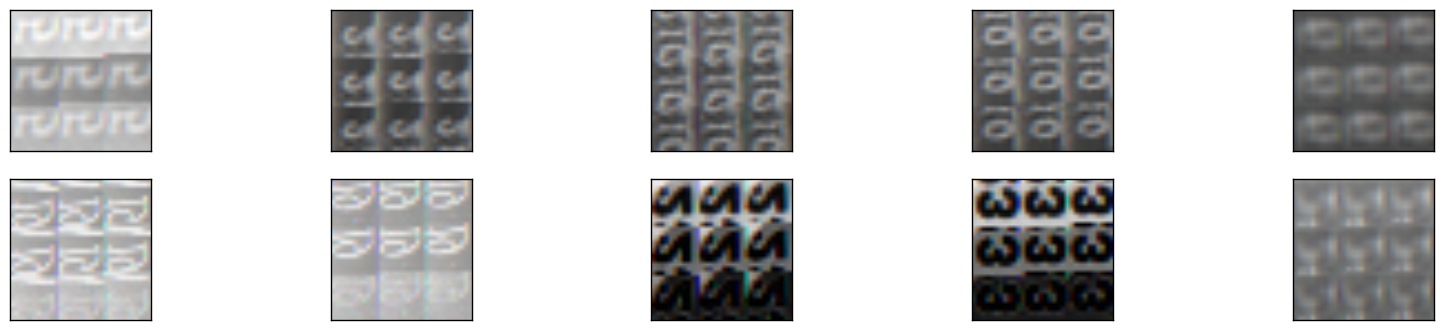

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 4))
n=5
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(32,32,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(X_train[i].reshape(32,32,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [3]:
from keras.utils import np_utils
X_train /= 255
X_test /= 255
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

In [ ]:
model = Sequential()
model.add(Convolution2D(16, 5, 5, border_mode='same', activation='relu',input_shape=(n_channels, n_rows, n_cols)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(512, 7, 7, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
model.summary()

In [56]:
model = load_model("convo3-1.h5")
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 16, 32, 32)    1216        convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 16, 16)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 512, 16, 16)   401920      maxpooling2d_1[0][0]             
____________________________________________________________________________________________________
maxpooling2d_2 (MaxPooling2D)    (None, 512, 8, 8)     0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [76]:
evalu = model.evaluate(X_test,Y_test)
print "Model Accuracy: {0}%".format(round(evalu[1],4)*100)

26032/26032 [==============================] - 74s    


In [ ]:
for convo in [7]:
    for pool in [4,2]:
        print "{0}x{0}/{1}x{1}".format(convo,pool)
        convmodel=load_model("convo/convo3-2-{0}x{0}-{1}x{1}.h5".format(convo,pool))
        ceval = convmodel.evaluate(X_test,Y_test)
        print "Model Accuracy: {0}%".format(round(ceval[1],4)*100)

Variaciones de capas convolucionales(3x3,5x5,7x7,9x9) y pooling(2x2,4x4)

|Conv/Pool|3x3/2x2|3x3/4x4|5x5/2x2|5x5/4x4|7x7/2x2|7x7/4x4|9x9/2x2|9x9/4x4|
|---|---|---|---|---|---|---|---|---|---|---|---|---|
|Tiempo Entrenamiento[seg]|347|320|366|334|436|404|464|431|
|Accuracy|95.3%|91.61%|93.65%|93.93%|-%|92.41%|90.0%|90.0%|

In [4]:
model = Sequential()
model.add(Convolution2D(16, 7, 7, border_mode='same', activation='relu',input_shape=(3,32,32)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(512, 7, 7, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
model.summary()
model.compile(loss='binary_crossentropy', optimizer="adagrad", metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=1280, nb_epoch=10, verbose=1,validation_data=(X_test, Y_test))
model.save("convo3-2-7x7-2x2.h5")
ceval = model.evaluate(X_test,Y_test)
print "Model Accuracy: {0}%".format(round(ceval[1],4)*100)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 16, 32, 32)    2368        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 16, 16)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 512, 16, 16)   401920      maxpooling2d_1[0][0]             
____________________________________________________________________________________________________
maxpooling2d_2 (MaxPooling2D)    (None, 512, 8, 8)     0           convolution2d_2[0][0]            
___________________________________________________________________________________________

MemoryError: Error allocating 671088640 bytes of device memory (out of memory).
Apply node that caused the error: GpuDownsampleFactorMaxGrad{(2, 2),True}(GpuElemwise{Composite{(i0 * (i1 + Abs(i1)))},no_inplace}.0, GpuDownsampleFactorMax{(2, 2),True}.0, GpuReshape{4}.0)
Toposort index: 110
Inputs types: [CudaNdarrayType(float32, 4D), CudaNdarrayType(float32, 4D), CudaNdarrayType(float32, 4D)]
Inputs shapes: [(1280, 512, 16, 16), (1280, 512, 8, 8), (1280, 512, 8, 8)]
Inputs strides: [(131072, 256, 16, 1), (32768, 64, 8, 1), (32768, 64, 8, 1)]
Inputs values: ['not shown', 'not shown', 'not shown']
Outputs clients: [[GpuElemwise{Composite{((i0 * i1) + (i0 * i1 * sgn(i2)))}}[(0, 1)](CudaNdarrayConstant{[[[[ 0.5]]]]}, GpuDownsampleFactorMaxGrad{(2, 2),True}.0, GpuElemwise{Add}[(0, 0)].0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.